# Import data from webhose.io

In [1]:
import os
import json
import webhoseio

data_path = './data'
model_path = './model'

### Useful function to write and read json files

In [2]:
def store_data(filename, data): 
    data_file = os.path.join(data_path, filename)
    with open(data_file, 'w') as outfile:
        json.dump(data, outfile)

def load_data(filename): 
    data_file = os.path.join(data_path, filename)
    with open(data_file) as json_data:
        data = json.load(json_data)
        return data

### Query to webhose.io

In [3]:
webhoseio.config(token="1a815770-8785-4596-a11c-09bdae034336")
query_params = {
    "q": "language:english site_type:news site_category:media organization:Microsoft", 
    "ts": "1555697996143",
    "sort": "crawled"
}

In [4]:
output = webhoseio.query("filterWebContent", query_params)
feeds = [ item for item in output['posts']]
while output['moreResultsAvailable'] > 0:
    output = webhoseio.get_next()
    feeds += [ item for item in output['posts']]

In [8]:
store_data('microsoft_0504_0604.json', feeds)

### We repeate the webhose query two time and here we merge the different files

In [9]:
def merge_files(file1, file2, new_file):
    data1 = load_data(file1)
    data2 = load_data(file2)
    data = data1 + data2 
    store_data(new_file, data)

In [10]:
merge_files('microsoft_0504_0604.json', 'microsoft_0604_0612.json', 'microsoft_webhose.json')

In [24]:
news_list = load_data('microsoft_webhose.json')
print('* Total number of news articles: {}'.format(len(news_list)))
print('* Date range: from {} to {}'.format(
    min([news_list[x]['published'] for x in range(len(news_list))]), 
    max([news_list[x]['published'] for x in range(len(news_list))])))

* Total number of news articles: 17123
* Date range: from 2019-05-04T03:00:00.000+03:00 to 2019-06-12T09:49:00.000+03:00



# Deduplicate titles 

In [13]:
import re
import time
import warnings
import numpy as np
import pandas as pd 

warnings.filterwarnings("ignore")

import nltk
from nltk.stem.wordnet import WordNetLemmatizer
stopwords = set(nltk.corpus.stopwords.words('english'))

from gensim.models import KeyedVectors
from simhash import Simhash, SimhashIndex

### Useful function to cleanup text and load word2vec 

In [14]:
def cleanup_text(text):
    text = re.sub(r'http\S+', '', text)
    text = text.replace("'s", " ")
    text = text.replace("n't", " not ")
    text = text.replace("'ve", " have ")
    text = text.replace("'re", " are ")
    text = text.replace("I'm"," I am ")
    text = text.replace("you're"," you are ")
    text = text.replace("You're"," You are ")
    text = text.replace("-"," ")
    text = text.replace("/"," ")
    text = text.replace("("," ")
    text = text.replace(")"," ")
    text = text.replace("%"," percent ")
    text = re.sub(r'[^a-zA-Z0-9 ]', '', text)
    text = " ".join([i for i in text.lower().split() if i not in stopwords])
    token = [WordNetLemmatizer().lemmatize(i) for i in text.split()]
    return token

def load_wordvec_model(modelName, modelFile, flagBin):
    model = KeyedVectors.load_word2vec_format(os.path.join(model_path, modelFile), binary=flagBin)
    return model

### Load word2vec and webhose data

In [16]:
model_w2v_AP = load_wordvec_model('Word2Vec Google News', 'GoogleNews-vectors-negative300.bin.gz', True)
data = load_data('microsoft_webhose.json')

### Get titles, cleanup text, and apply Simhash

In [25]:
tot_title = len(data)
title_list = [' '.join(cleanup_text(str(data[i]['title']))) for i in range(tot_title)]
objs = [(i, Simhash(title_list[i])) for i in range(tot_title)]

#### Function checks whether the input words are present in the vocabulary for the model

In [26]:
def vocab_check(vectors, words):
    output = list()
    for word in words:
        if word in vectors.vocab:
            output.append(word.strip())
    return output

#### Function calculates similarity between two strings using a particular word vector model

In [27]:
def calc_similarity(input1, input2, vectors):
    s1words = set(vocab_check(vectors, input1.split()))
    s2words = set(vocab_check(vectors, input2.split()))
    
    output = vectors.n_similarity(s1words, s2words)
    return output

### Remove duplicate titles

In [41]:
def remove_duplicate(index, title_list, index_simahs, model_w2v_AP):
    duplicates = set()
    title = title_list[index]
    
    # calculate  hash value
    title_hash = Simhash(title)
    
    # find all duplicate indices
    dup_indices = index_simahs.get_near_dups(title_hash)

    # apply word2vec 
    for dupi in dup_indices:
        if int(dupi) == index: 
            continue
        try:
            score = calc_similarity(title, title_list[int(dupi)], model_w2v_AP)
        except:
            score = 0
        if score > 0.55:
            duplicates.add(int(dupi))
    return duplicates 

distance = 15
index_simahs = SimhashIndex(objs, k=distance)

index = 4401
print('Title: \n' + data[index]['title'] + '\n\nDuplicates:')
for i in remove_duplicate(index, title_list, index_simahs, model_w2v_AP): 
    print(data[i]['title'])

Title: 
ArcBlock Joins the Decentralized Identity Foundation to Help Make Blockchain-based ID Systems a Reality

Duplicates:
ArcBlock Joins the Decentralized Identity Foundation to Help Make Blockchain-based ID Systems a Reality


In [21]:
start = time.clock()
duplicates = set()
for index in range(tot_title): 
    if index in duplicates: 
        continue 
    new_duplicates = remove_duplicate(index, title_list, index_simahs, model_w2v_AP);
    duplicates = duplicates.union(new_duplicates)
    if index % 5000 == 0 and index != 0: 
        print(str(index) + '/' + str(tot_title), len(duplicates), time.clock() - start)
    
new_feeds = data.copy()
for dup in sorted([int(dup) for dup in duplicates], reverse=True):
    del new_feeds[dup]

KeyboardInterrupt: 

In [ ]:
store_data('microsoft_clean.json', new_feeds)

In [42]:
news_cleaned_list = load_data('microsoft_clean.json')
print('* Total number of news articles once removed duplicates: {}'.format(len(news_cleaned_list)))
print('* Date range: from {} to {}'.format(
    min([news_list[x]['published'] for x in range(len(news_cleaned_list))]), 
    max([news_list[x]['published'] for x in range(len(news_cleaned_list))])))

* Total number of news articles once removed duplicates: 14099
* Date range: from 2019-05-04T03:00:00.000+03:00 to 2019-06-12T09:49:00.000+03:00


# Name Entity Recognition using IBM Watson

In [10]:
from watson_developer_cloud import NaturalLanguageUnderstandingV1
from watson_developer_cloud.natural_language_understanding_v1 import Features, EntitiesOptions, KeywordsOptions

In [11]:
data = load_data('microsoft_clean.json') 

### Query to IBM Watson

In [12]:
natural_language_understanding = NaturalLanguageUnderstandingV1(
    version='2018-11-16',
    iam_apikey='N9R1KBh-8CJVJWSMGHB_lLG-Sq03-BurNjDc_dh5l9Id',
    url='https://gateway.watsonplatform.net/natural-language-understanding/api/v1/analyze?version=2018-11-16'
)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: NaturalLanguageUnderstandingV1 is a deprecated function. watson-developer-cloud moved to ibm-watson
  after removing the cwd from sys.path.


In [17]:
def get_title_WATSON_entities(text):
    entities_dict = dict()
    r = natural_language_understanding.analyze(
        text=text, features=Features(entities=EntitiesOptions(sentiment=True, limit=10))).get_result()
    for entity in r['entities']:
        entities_dict[entity['type']] = entity['text']
    return entities_dict

title = data[11]['title']
print(title)
get_title_WATSON_entities(title)

CBSE 10th Result 2019: Candidates can use alternative methods to provided by Google, Microsoft if official website is down


{'Company': 'Microsoft', 'JobTitle': 'official', 'Organization': 'CBSE'}

In [18]:
start = time.clock()
for i in range(len(data)): 
    title = data[i]['title']
    try:
        entities = get_title_WATSON_entities(title)
    except Exception:
        entities = dict()
    data[i]['title_entities'] = entities
    if index % 5000 == 0 and index != 0: 
        print(str(index) + '/' + str(len(data)), time.clock() - start)

In [18]:
store_data('microsoft_clean_with_entities.json', data)

NameError: name 'data' is not defined

In [19]:
news_cleaned_list = load_data('microsoft_clean_with_entities.json')
entity_title_list = [news['title_entities'] for news in news_cleaned_list if len(news['title_entities'].keys()) > 0]
tot_entities_dict = dict()
for entity_title in entity_title_list: 
    for entity in entity_title:
        if entity in tot_entities_dict.keys():
            tot_entities_dict[entity] += [entity_title[entity]]
        else:
            tot_entities_dict[entity] = [entity_title[entity]]
print('* Total number of news entities: {}'.format(len(tot_entities_dict)) + '\n')
print('* List of entities find in titles:\n -' + '\n -'.join(list(tot_entities_dict.keys())) + '\n')
print('* List of words associated with Broadcaster:\n -' + '\n -'.join(list(set(tot_entities_dict['Broadcaster']))))

* Total number of news entities: 27

* List of entities find in titles:
 -Person
 -Company
 -JobTitle
 -Location
 -GeographicFeature
 -Organization
 -Quantity
 -PrintMedia
 -Facility
 -Sport
 -Broadcaster
 -Number
 -Drug
 -Hashtag
 -HealthCondition
 -TwitterHandle
 -IPAddress
 -Movie
 -Date
 -Crime
 -Measure
 -MusicGroup
 -Money
 -TelevisionShow
 -Vehicle
 -Award
 -Percent

* List of words associated with Broadcaster:
 -FOX News
 -CNN
 -ABC
 -KTLA
 -HBO
 -BBC News
 -TMZ
 -CBS
 -NBC
 -Fox News


In [68]:
from collections import Counter
list_words = [text[1] for entity in entity_title_list for text in entity.items()]
counts = Counter(list_words)
print('word       |  count ')
for i in counts.most_common(25): 
    print('{:<10} | {}'.format(i[0], i[1]))

word       |  count 
Microsoft  | 915
Huawei     | 100
Google     | 92
Apple      | 60
US         | 47
Amazon     | 47
CNET       | 42
Sony       | 40
AI         | 36
Facebook   | 34
CEO        | 32
China      | 31
India      | 28
Chicago    | 22
UK         | 21
Bill Gates | 16
MSFT       | 16
Africa     | 16
partner    | 15
Samsung    | 15
Coast Live | 15
IBM        | 14
Twitter    | 14
U.S.       | 14
Intel      | 13


# Topic cluster using LDA

In [43]:
from gensim.models import ldamodel
from gensim.corpora.dictionary import Dictionary
import pyLDAvis.gensim

In [44]:
data = load_data('microsoft_clean.json') 
titles = [[data[i]['title'], data[i]['published'][:10]]  for i in range(len(data))]
df_feeds = pd.DataFrame(titles,columns=['title', 'date'])
titles = df_feeds[['title']].applymap(cleanup_text)['title']

In [45]:
dictionary = Dictionary(titles)
dictionary.filter_extremes(no_below=20, no_above=0.8)
corpora = [dictionary.doc2bow(doc) for doc in titles]

# Running and Trainign LDA model on the document term matrix.
lda_model = ldamodel.LdaModel(corpora, num_topics=10, id2word = dictionary, passes=50)

In [46]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpora, dictionary)
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
8      12.907335        1       1 -0.038864 -0.299552
9      11.634643        1       2  0.211823  0.122330
0      11.077435        1       3  0.150591  0.025665
5      10.976942        1       4  0.060262 -0.260276
3       9.447737        1       5  0.001795  0.164878
4       9.334929        1       6 -0.318196  0.158850
7       9.241575        1       7  0.076132  0.054459
6       9.109207        1       8 -0.071404 -0.016635
2       8.347623        1       9  0.132823  0.087296
1       7.922578        1      10 -0.204962 -0.037014, topic_info=     Category         Freq          Term        Total  loglift  logprob
term                                                                   
38    Default  1344.000000          2019  1344.000000  30.0000  30.0000
26    Default   896.000000        window   896.000000  29.0000  29.0000
828   Default   712.000000            e3   712.000000  28.0000  28.0000
40    Default   585.000000        google   585.000000  27.0000  27.0000
85    Default   930.000000          xbox   930.000000  26.0000  26.0000
21    Default   574.000000            10   574.000000  25.0000  25.0000
31    Default   836.000000          game   836.000000  24.0000  24.0000
839   Default   517.000000           usa   517.000000  23.0000  23.0000
110   Default   488.000000        market   488.000000  22.0000  22.0000
3     Default  2824.000000     microsoft  2824.000000  21.0000  21.0000
70    Default   484.000000          data   484.000000  20.0000  20.0000
16    Default   338.000000         azure   338.000000  19.0000  19.0000
239   Default   301.000000           get   301.000000  18.0000  18.0000
154   Default   386.000000           one   386.000000  17.0000  17.0000
732   Default   285.000000            pc   285.000000  16.0000  16.0000
14    Default   350.000000          tech   350.000000  15.0000  15.0000
24    Default   363.000000        update   363.000000  14.0000  14.0000
125   Default   472.000000          news   472.000000  13.0000  13.0000
214   Default   360.000000             2   360.000000  12.0000  12.0000
118   Default   229.000000          msft   229.000000  11.0000  11.0000
160   Default   257.000000           top   257.000000  10.0000  10.0000
330   Default   323.000000    technology   323.000000   9.0000   9.0000
37    Default   330.000000           may   330.000000   8.0000   8.0000
86    Default   238.000000     developer   238.000000   7.0000   7.0000
108   Default   266.000000      business   266.000000   6.0000   6.0000
385   Default   217.000000      security   217.000000   5.0000   5.0000
326   Default   229.000000        huawei   229.000000   4.0000   4.0000
104   Default   279.000000      software   279.000000   3.0000   3.0000
115   Default   189.000000            co   189.000000   2.0000   2.0000
425   Default   195.000000     assistant   195.000000   1.0000   1.0000
...       ...          ...           ...          ...      ...      ...
583   Topic10    77.057480        school    77.989174   2.5234  -4.2977
395   Topic10    76.625687      computer    77.557434   2.5234  -4.3033
660   Topic10    74.153557          2016    75.085358   2.5230  -4.3361
171   Topic10    72.092522        people    73.024261   2.5226  -4.3643
204   Topic10    71.674522           way    72.606262   2.5225  -4.3701
756   Topic10    68.365150     executive    69.296913   2.5219  -4.4174
866   Topic10    67.259247         trial    68.190956   2.5217  -4.4337
927   Topic10    67.138206            en    68.070221   2.5217  -4.4355
5     Topic10    66.864899          high    67.796669   2.5216  -4.4396
693   Topic10    64.988457      training    65.920197   2.5212  -4.4681
727   Topic10    58.403107          meet    59.335022   2.5196  -4.5749
491   Topic10    57.553024         house    58.484734   2.5194  -4.5896
672   Topic10    56.924549       account    57.856270   2.5192  -4.60

In [47]:
def get_term_by_topic(lda_model, dictionary, topic_id):
    for item in lda_model.get_topic_terms(topic_id): 
        term = dictionary[item[0]]
        print(" " + term)
    return 

for i in range(10):
    print('Main term in topic {}'.format(i))
    get_term_by_topic(lda_model, dictionary, i)
    print()

Main term in topic 0
 usa
 microsoft
 azure
 news
 developer
 new
 edge
 service
 platform
 digital

Main term in topic 1
 de
 trailer
 new
 work
 use
 la
 online
 create
 driver
 sql

Main term in topic 2
 microsoft
 msft
 co
 job
 management
 ai
 share
 life
 company
 director

Main term in topic 3
 microsoft
 data
 business
 security
 window
 system
 software
 analyst
 support
 update

Main term in topic 4
 window
 10
 update
 engineer
 u
 manager
 1
 access
 tech
 support

Main term in topic 5
 xbox
 game
 get
 one
 microsoft
 pc
 new
 huawei
 minecraft
 coming

Main term in topic 6
 tech
 assistant
 2019
 excel
 microsoft
 june
 pro
 deal
 data
 office

Main term in topic 7
 google
 microsoft
 sony
 say
 apple
 stadium
 console
 amazon
 launch
 health

Main term in topic 8
 2019
 e3
 game
 xbox
 2
 may
 new
 video
 release
 5

Main term in topic 9
 market
 microsoft
 technology
 top
 cloud
 2019
 global
 open
 million
 key



# Topic cluster

In [48]:
import gensim, operator
from scipy import spatial

In [49]:
topic_taxonomy = {
    "Business Operations" : 
    {
        "Business" : "apple ceo business global trend finance",
    },
    
    "Stock" :
    {
        "Market" : "data software business technology growth msft share price future deal",
        "Competition" : "google facebook ceo ibm oracle huawei apple"
    },
    
    "Gaming" :
    {
        "Product-gaming" : "announce trailer event video release",
        "Game" : "game e3 xbox playstation console minecraft",
        
    },
    
    "Technology" : 
    {
        "Windows" : "fix 10 server build google",
        "Security" : "upgrade cyber punk hack avast system update",
        "AI" : "artificial intelligence future technology",
        "Data": "data cloud computing blockchain amd bitcoin",
        "Product-technology" : "team azure 365 office pro launch excel pc edge outlook",
    },
    
    "Gates":
    {
        "People": "bill melinda ellen show bezos",
        "Charity": "donation unicef un foundation"
    },
    
    "Employment":
    {
        "Location" : "palo alto bangalore new york africa",
        "Visa" : "h1b trump immigration china india",
        "Jobs": "engineer machine learning ai analyst management developer"
    },
    
    "Clients":
    {
        "Customer": "platform service"
    }
}

In [50]:
def classify_topics(input, vectors):
    feed_score = dict()
    for key, value in topic_taxonomy.items():
        max_value_score = dict()
        for label, keywords in value.items():
            max_value_score[label] = 0
            topic = (keywords).strip()
            max_value_score[label] += float(calc_similarity(input, topic, vectors))
            
        sorted_max_score = sorted(max_value_score.items(), key=operator.itemgetter(1), reverse=True)[0]
        feed_score[sorted_max_score[0]] = sorted_max_score[1]
    result = sorted(feed_score.items(), key=operator.itemgetter(1), reverse=True)[:3]
    if result[0][1] < 0.4:
        return []
    return result

In [51]:
data = load_data('microsoft_clean.json')
tot_title = len(data)
title_list = [(' '.join(cleanup_text(str(data[i]['title']))), data[i]['published'][:10]) for i in range(tot_title)]

In [53]:
title_id = 10892
print("Title classified: {}".format(data[title_id]['title']))
classification = classify_topics(title_list[title_id][0], model_w2v_AP)
print(classification)

Title classified: Windows 10 1903 Cumulative Update KB4497935 Takes Care of High-Priority Bugs and Software Issues
[('Security', 0.5159127116203308), ('Market', 0.4831184446811676), ('Product-gaming', 0.3456571102142334)]


### Main topic day by day 

In [75]:
topics_by_date = dict()
for date in set([date[1] for date in title_list]):
    topics_by_date[date] = dict() 

for title in title_list: 
    try:
        topics = classify_topics(title[0], model_w2v_AP)
        if len(topics) == 0:
            continue
    except Exception: 
        continue
    
    date = title[1]
    for topic in topics:
        if topic[0] not in topics_by_date[date].keys(): 
            topics_by_date[date][topic[0]] = 1 
            break
        else: 
            topics_by_date[date][topic[0]] += 1

In [79]:
def get_main_topics(topics_by_date, date):
    topics = topics_by_date[date]
    return sorted(topics.items(), key=operator.itemgetter(1), reverse=True)[:3]

for date in sorted(set([date[1] for date in title_list])):
    topics = get_main_topics(topics_by_date, date)
    print('On {} the main topics are: {}'.format(date, ', '.join([topic[0] for topic in topics])))

On 2019-05-04 the main topics are: Competition, Market, Windows
On 2019-05-05 the main topics are: Competition, Game, Windows
On 2019-05-06 the main topics are: Competition, Market, Game
On 2019-05-07 the main topics are: Competition, Game, Market
On 2019-05-08 the main topics are: Competition, Market, Game
On 2019-05-09 the main topics are: Competition, Market, Windows
On 2019-05-10 the main topics are: Competition, Market, Location
On 2019-05-11 the main topics are: Competition, Market, Windows
On 2019-05-12 the main topics are: Competition, Game, Product-technology
On 2019-05-13 the main topics are: Competition, Market, Game
On 2019-05-14 the main topics are: Market, Competition, Location
On 2019-05-15 the main topics are: Competition, Market, Game
On 2019-05-16 the main topics are: Market, Competition, Product-technology
On 2019-05-17 the main topics are: Competition, Game, Market
On 2019-05-18 the main topics are: Competition, Game, Windows
On 2019-05-19 the main topics are: Marke

# Microsoft stock prices

In [9]:
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from iexfinance.stocks import Stock
from iexfinance.stocks import get_historical_data

In [12]:
def get_prices(stock_name, t1, t2): 
    start = t1
    end = t2 
    stock = Stock(stock_name)
    return get_historical_data(stock_name, start=start, end=end, output_format='pandas')

def plot_candlestick(df):
    df["color"] = (df.close > df.open).map({True:"green",False:"red"})
    fig, ax = plt.subplots()
    for date in df.index:
        ax.plot([date]*2, df.loc[date, ["high","low"]].values, color = "black")
        ax.plot([date]*2, df.loc[date, ["open","close"]].values, color = df.loc[date, "color"], linewidth = 10)

    ax.set_ylabel("Price [$]")
    ax.set_xlabel("Day")
    ax.set_title("OHLC of Stock Value During Trading Day")
    plt.show()

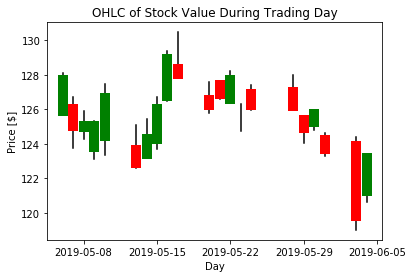

In [13]:
df = get_prices('MSFT', datetime.date(2019,5,4), datetime.date(2019,6,4))
plot_candlestick(df)